In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets

import seaborn as sns

In [2]:
%matplotlib inline
sklearn.__version__ 

'0.23.2'

# Linear Regression with Numpy (only)

### Let's read the file containing our data
Pandas provides an easier way to read the data and convert to numpy

In [3]:
data_df = sklearn.datasets.load_diabetes(as_frame=True).data
data_df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


In [4]:
data_arr = data_df.values
data_arr

array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
         0.01990842, -0.01764613],
       [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
        -0.06832974, -0.09220405],
       [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
         0.00286377, -0.02593034],
       ...,
       [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
        -0.04687948,  0.01549073],
       [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
         0.04452837, -0.02593034],
       [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
        -0.00421986,  0.00306441]])

In [5]:
data_arr.shape

(442, 10)

#### Extract X, y

In [6]:
X_raw = data_arr[:,1:] # get everything but the first column
y_raw = data_arr[:, :1]# get the first column (I'm not just doing data_arr[:,-1] to avoid (x,) dimensions)

In [7]:
X_raw.shape, y_raw.shape

((442, 9), (442, 1))

#### Normalize data

In [8]:
#X_raw = X_raw / X_raw.sum()
#y_raw = y_raw / y_raw.sum()

#### Add bias to data

In [9]:
X = np.hstack((np.ones(y_raw.shape),X_raw))
y = y_raw

In [10]:
X.shape, y.shape

((442, 10), (442, 1))

In [11]:
X.dtype, y.dtype

(dtype('float64'), dtype('float64'))

#### Use gradient descent to solve for coefficients

In [12]:
learning_rate = 0.001
iterations = 100_000

features = X.shape[1]

In [13]:
w = np.ones((features,1))

for i in range(iterations):
    w -= (learning_rate) * (2) * X.T.dot(X.dot(w) - y)

In [14]:
w.flatten()

array([-2.55060648e-16,  1.01277512e-01, -6.76914720e-03,  2.08303643e-01,
       -1.54614645e-01,  2.57139276e-01,  1.44146331e-01, -3.60377426e-02,
        1.86787024e-01,  1.45283237e-01])

##### MSE

In [15]:
observations = X.shape[0]
np.sum((X.dot(w) - y)**2)/ (observations)

0.0018585909503712748

#### Try again, but do a grid search for hyper parameters

In [16]:
learning_rate_list = [0.001, 0.0001, 0.00001]
iteration_list = [100, 1_000, 10_000, 100_000]

hyper_parameters = list()

for learning_rate in learning_rate_list:
    print(f"Trying learning rate {learning_rate} and batch size {iterations}")
    for iterations in iteration_list:
        w = np.ones((features,1))
        for i in range(iterations):
            w -= (learning_rate) * (2) * X.T.dot(X.dot(w) - y)
            error = np.sum(X.dot(w) - y) # not squared to avoid overflow error
        hyper_parameters.append((learning_rate, iterations, error))

Trying learning rate 0.001 and batch size 100000
Trying learning rate 0.0001 and batch size 100000
Trying learning rate 1e-05 and batch size 100000


#### Cleaner version of the same code

In [17]:
def fit(X, y, iterations=10000, learning_rate=0.0001, callback=None, callback_freq=100_000):

    observations = X.shape[0]
    features = X.shape[1]

    w = np.ones((features,1))

    predictor = lambda X: X.dot(w)
    mse       = lambda X, y: np.sum((predictor(X) - y)**2)/observations

    errors = np.zeros(iterations)
    for i in range(iterations): 
        prediction = predictor(X)
        error = prediction - y
        errors[i] = mse(X, y)
        if callback and i % callback_freq == 0: callback(i, w, errors[i])
        #gradient = (2/observations) * X.T.dot(error)
        gradient =  2 * X.T.dot(error)
        w -= learning_rate * gradient
    
    return predictor, w, mse, errors

In [18]:
%%time 

learning_rate_list = [0.001, 0.0001]
iteration_list = [10, 100, 1_000, 10_000, 100_000]

callback = lambda i, w, e:print(e)

hyper_parameters = list()

for learning_rate in learning_rate_list:
    for iterations in iteration_list:
        
        print(f"Trying learning rate {learning_rate} and batch size {iterations}")
        
        predictor, w, mse, errors = fit(X, y, iterations = iterations, learning_rate=learning_rate, callback=None)
        hyper_parameters.append((learning_rate, iterations, mse(X, y), errors))

Trying learning rate 0.001 and batch size 10
Trying learning rate 0.001 and batch size 100
Trying learning rate 0.001 and batch size 1000
Trying learning rate 0.001 and batch size 10000
Trying learning rate 0.001 and batch size 100000
Trying learning rate 0.0001 and batch size 10
Trying learning rate 0.0001 and batch size 100
Trying learning rate 0.0001 and batch size 1000
Trying learning rate 0.0001 and batch size 10000
Trying learning rate 0.0001 and batch size 100000
Wall time: 5.95 s


In [19]:
#hyper_parameters

In [20]:
pd.DataFrame({'a':1, 'b':2, 'c':[1,2,3]})

,a,b,c
0,1,2,1
1,1,2,2
2,1,2,3


In [21]:
dfs = list()
for hp in hyper_parameters:
    lr, epoch, mse, errors = hp
    error_indexes = list(range(len(errors)))
    dfs.append(pd.DataFrame({'lr':lr, 'epoch':epoch, 'mse':mse, 'error':errors, 'error_indexes':error_indexes}))

hyper_parameters_df = pd.concat(dfs)

In [22]:
hyper_parameters_df

,lr,epoch,mse,error,error_indexes
0,0.0010,10,0.041467,1.047581,0
1,0.0010,10,0.041467,0.060383,1
2,0.0010,10,0.041467,0.046463,2
3,0.0010,10,0.041467,0.045650,3
4,0.0010,10,0.041467,0.045023,4
...,...,...,...,...,...
99995,0.0001,100000,0.001864,0.001864,99995
99996,0.0001,100000,0.001864,0.001864,99996
99997,0.0001,100000,0.001864,0.001864,99997
99998,0.0001,100000,0.001864,0.001864,99998


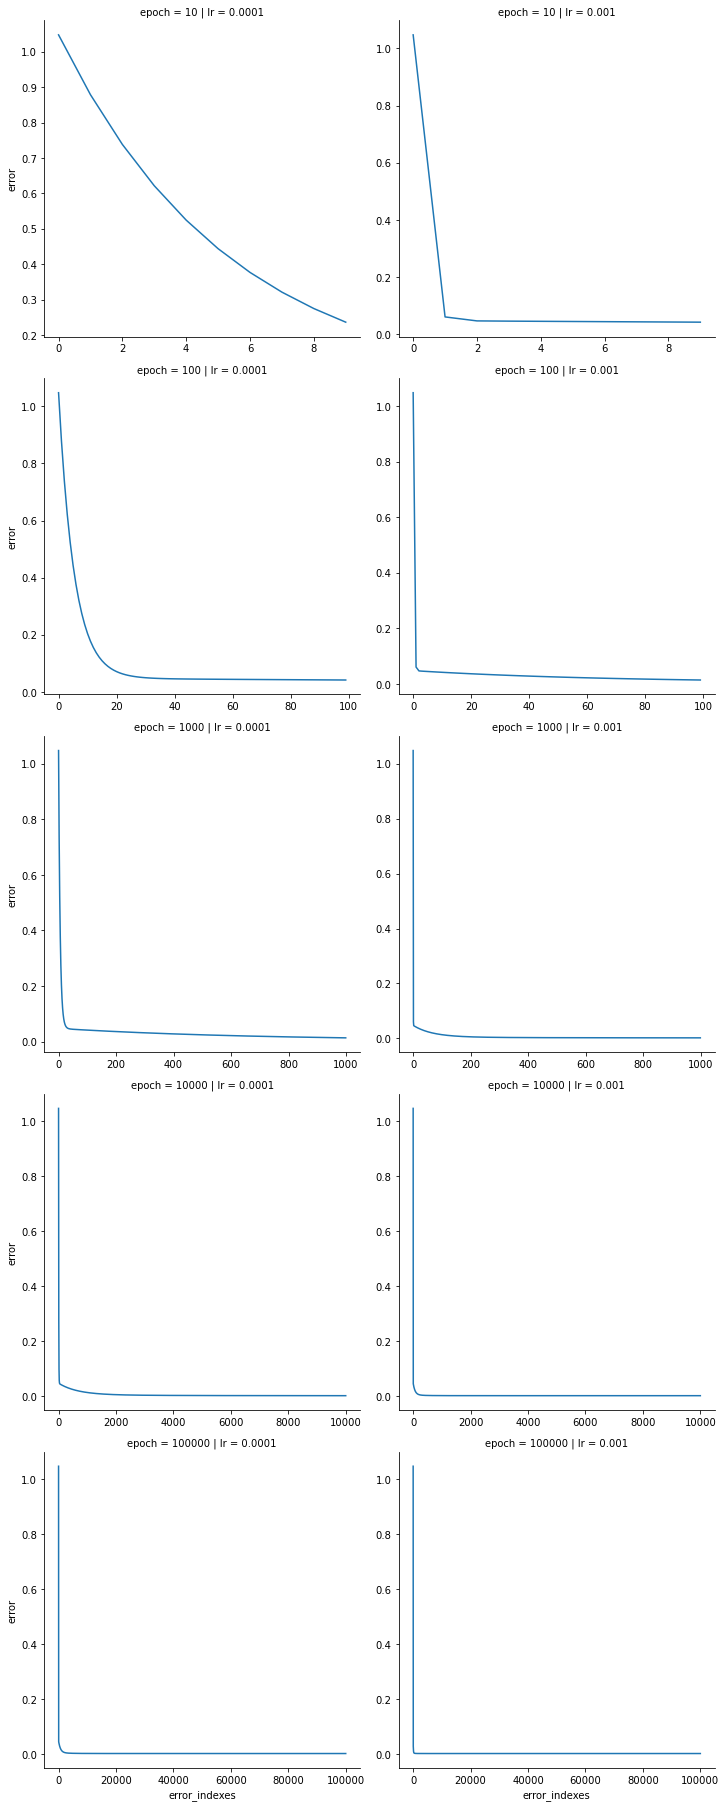

In [23]:
sns.relplot(x='error_indexes'
            , y='error'
            , col='lr'
            , row='epoch'
            , data=hyper_parameters_df
            , kind='line'
            , facet_kws={'sharey':False, 'sharex':False})

### Check work

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

%time reg = LinearRegression(fit_intercept=False).fit(X, y)

Wall time: 14.8 ms


In [30]:
reg.coef_.flatten()

array([-3.63384527e-16,  1.01423703e-01, -6.46819368e-03,  2.08210778e-01,
       -1.28652960e-01,  2.36555609e-01,  1.32543572e-01, -3.93591269e-02,
        1.77129246e-01,  1.45396289e-01])

In [26]:
mean_squared_error(y, reg.predict(X))

0.0018585650342457752

In [32]:
w.flatten()

array([-2.60170186e-16,  1.00596731e-01, -7.74762811e-04,  2.13417822e-01,
       -2.56879239e-01,  2.72944400e-01,  2.67100964e-01,  1.05029981e-01,
        1.90884570e-01,  1.42513077e-01])

In [28]:
mean_squared_error(y, X.dot(w))

0.001864051577356926